<center><h2><font face="Georgia" color="#33A1C9"> Heavy Water: Classification Test </font></h2>
<h5><font face="Georgia"> Submitted by - Saurabh Shertukde (sshertuk@andrew.cmu.edu) </font></h5></center>

##### Import required libraries

In [1]:
# import libraries required for computations
import pandas as pd
import numpy as np
import time
import pickle as pkl

#import libraries required for building prediction models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Import libraries required for plotting graphs
from termcolor import colored
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

##### Function to print values

In [2]:
# define a function to print values to console
def printVals(x, y):
    text = colored(x,'blue')
    val = colored(y, 'green')
    print (text, val)

##### Load the dataset

In [3]:
df = pd.read_csv("shuffled-full-set-hashed.csv", names = ['Category', 'Content'])

df.shape

(62204, 2)

In [4]:
df.head(5)

,Category,Content
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...


<h3><font face="Georgia" color="#00E5EE"><center>Data Exploration & Wrangling</center></font></h3>

#### Deduplication

In [5]:
df.duplicated().value_counts()

False    60548
True      1656
dtype: int64

In [6]:
df.drop_duplicates(keep='first', inplace=True)

#### Check Missing Values

In [7]:
#check null values per column/attribute
df.isnull().sum()

Category    0
Content     6
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
#final record count after cleaning
df.shape

(60542, 2)

#### Explore the Target

In [10]:
df['Category'].value_counts()

BILL                       18449
POLICY CHANGE              10229
CANCELLATION NOTICE         9571
BINDER                      8590
DELETION OF INTEREST        4779
REINSTATEMENT NOTICE        4295
DECLARATION                  966
CHANGE ENDORSEMENT           866
RETURNED CHECK               730
EXPIRATION NOTICE            719
NON-RENEWAL NOTICE           618
BILL BINDER                  277
INTENT TO CANCEL NOTICE      227
APPLICATION                  226
Name: Category, dtype: int64

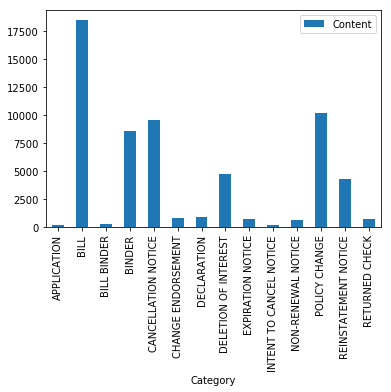

In [11]:
fig = plt.figure(figsize=(8,6))

df.groupby('Category').count().plot.bar(ylim=0)

plt.show()

Given the clear imbalance in data, we will oversample the data before modeling.

#### Factorize the Categories

In [12]:
#encode labels to numeric so that each number corresponds to a document class
df['Label'] = df['Category'].factorize()[0]
df.head(5)

,Category,Content,Label
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...,0
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...,1
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...,2
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...,2
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...,2


In [13]:
category_id_df = df[['Category', 'Label']].drop_duplicates().sort_values('Label')
category_id_df

,Category,Label
0,DELETION OF INTEREST,0
1,RETURNED CHECK,1
2,BILL,2
5,POLICY CHANGE,3
8,CANCELLATION NOTICE,4
15,DECLARATION,5
18,CHANGE ENDORSEMENT,6
19,NON-RENEWAL NOTICE,7
20,BINDER,8
29,REINSTATEMENT NOTICE,9


In [14]:
#create a utility map for future prediction purposes
category_to_id = dict(category_id_df.values)

id_to_category = dict(category_id_df[['Label', 'Category']].values)
id_to_category

{0: 'DELETION OF INTEREST',
 1: 'RETURNED CHECK',
 2: 'BILL',
 3: 'POLICY CHANGE',
 4: 'CANCELLATION NOTICE',
 5: 'DECLARATION',
 6: 'CHANGE ENDORSEMENT',
 7: 'NON-RENEWAL NOTICE',
 8: 'BINDER',
 9: 'REINSTATEMENT NOTICE',
 10: 'EXPIRATION NOTICE',
 11: 'INTENT TO CANCEL NOTICE',
 12: 'APPLICATION',
 13: 'BILL BINDER'}

<h3><font face="Georgia" color="#00E5EE"><center>Data Modeling</center></font></h3>

#### Create the Test, Training and Validation Sets

In [15]:
# SPLIT TRAIN AND TEST SETS
mask = np.random.rand(len(df)) < 0.9

train = df[mask]
test = df[~mask]

#save (one-time) test data for manual testing
#test.to_csv('test_data.csv', sep=',', encoding='utf-8')

In [16]:
# TEST SET
X_test = test['Content']
y_test = test['Label']

In [17]:
# TRAIN SET
X = train['Content']
y = train['Label']

In [18]:
# SPLIT TRAIN AND VALIDATION SETS
VAL_SIZE = 0.2
RANDOM_STATE = 0

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SIZE, random_state=RANDOM_STATE)

In [19]:
X_train.shape, y_train.shape

((43562,), (43562,))

In [20]:
X_val.shape, y_val.shape

((10891,), (10891,))

In [21]:
X_test.shape, y_test.shape

((6089,), (6089,))

In [22]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_val_counts = count_vect.transform(X_val)
X_test_counts = count_vect.transform(X_test)

#Counts
X_train_counts.shape

(43562, 803205)

In [23]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_val_tfidf = tfidf_transformer.transform(X_val_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

#Counts
X_train_tfidf.shape

(43562, 803205)

#### Function to Build, Predict and Summarize a Model

In [24]:
def buildModel(model):
    # train
    model.fit(X_train_tfidf, y_train)

    # predict
    y_pred = model.predict(X_val_tfidf)  
    
    #test_predict
    vals = model.predict(count_vect.transform(['cd50e861f48b 6ca2dd348663 d38820625542 f07761418345 5948001254b3 9997460cf372 3f7a70f3474f 6bc122aa4b06 b4f1b88bd3f3 25c57acdf805 54709b24b45f 51fc8b56e14f ff714b9fa7fd 798fe9915030 2d5d7bc2df91 6b583fe13e39 8e93a2273a93 3d877a3bc4f0 ff1c26ea0b6f d9ef68daef4c 9a42ead47d1c 5cde1ed4f9b0 a20e78c41cf9 dec88250479b ecee69844b4e 87b8193a0183 0c470ee92bb5 cd50f04925dd 878460b4304e b4f1b88bd3f3 133d46f7ed38 d38820625542 f682089485c3 96776b42c1d5 51fc8b56e14f 3f7a70f3474f d911e9441d32 c16651ffa1b7 9374c105ef84 f8b0c07e306c d38820625542 e0a08df8ec4c f8dab246f73f 878460b4304e 3f7a70f3474f b4f1b88bd3f3 6ce6cc5a3203 b4f1b88bd3f3 ddf4525e90e3 55b85f1ee56e c63534ebfa82 878460b4304e 9448e1c70dec 1932d6ce3497 8243aca146b2 2ea49cf89745 ff714b9fa7fd e4dad7cb07b6 ff714b9fa7fd 549330b9e320 f7bb594ff117 e63fa74d3c8b df03d288b8b6 cd50e861f48b f7bb594ff117 a1bb6b4223d9 ba02159e05b1 37ac79620fc6 1087de55f102 80948b43ec70 d9fc2cff7e21 abca9d18fae2 6cfef272bdb9 9d83e581af4b cc9e05bc2a86 cbd0a3abbc34 69954839bb65 cd50f04925dd 431392fb12c7 ecee69844b4e 36e7aa72ffe1 0b3f3d23bd37 8cb71bb0ee27 ff714b9fa7fd a87473e878c1 a1bb6b4223d9 f7bb594ff117 dff2d27792d5 ff714b9fa7fd 83f8b75d8fe3 22f8fa324aed 58b1c79289d7 5948001254b3 9997460cf372 da9ad7407226 a263b63bc282 011113964d37 da9ad7407226 b73e657498f2 17c11ac4749f ee8125ecd585 0cbca93be301 ea95010f229b b13cff832743 cf4fc632eed2 b4f1b88bd3f3 6b343f522f78 4ea48dbbe14e 5f9c2ac954be 61e151399c9d 7b477e3d63d2 cdc95c39cac8 f07761418345 22fa1184be26 d9ef68daef4c d944e076fa92 f7ae6f8257da 87b8193a0183 11269ab19093 6cfef272bdb9 8ebb4fffd292 d38820625542 6469b7eeb029 98b0900e06f4 1b6c95839a6d 44c1e122f3f0 d38820625542 cfd22ba194a9 828e5c947b2b 7860028b1d17 6dbd5ceef3d1 f60bd1bc4fe5 05b8cb495fc2 9d83e581af4b d38820625542 7d9e333a86da 6cfef272bdb9 9d83e581af4b 133d46f7ed38 1087de55f102 ef4ba44cdf5f b02eb907dd1a 35991d8609e2 29f6e5802d4f 133d46f7ed38 874b796362b6 e943e5e5b779 4d28878de1db d1c3631d621b 7d9e333a86da d38820625542 133d46f7ed38 1b7657be8986 1ab34730c1e0 f7bb594ff117 ff714b9fa7fd 8502c0087099 58b1c79289d7 cd50f04925dd ecee69844b4e 431392fb12c7 1b3e5dc39eb9 586242498a88 5680bf4cc121 69c87281a156 c8207fafe699 cd50f04925dd ff714b9fa7fd 8502c0087099 ecee69844b4e 8cb71bb0ee27 386e8b20726f a1bb6b4223d9 6bf9c0cb01b4 142d16db61dd 60d18132df81 dab42b5e7528 259218088611 135307dba198 b73e657498f2 26f7353edc2e cd50f04925dd d38820625542 133d46f7ed38 f7bb594ff117 ecee69844b4e 1ab34730c1e0 e943e5e5b779 a87473e878c1 57d5616683d8 54fb27d07530 afab4a5c0f58 83da9eb0a417 619c02c2888a 11269ab19093 fb82195dee42 b7a0f56f6ce8 2d5d7bc2df91 6b583fe13e39 798fe9915030 586242498a88 0662d94b3d3b b7ab56536ec4 f54a40468e55 14bc74b659ac 7498a1e9d9d7 ac624879ac84 6bc122aa4b06 868759570f1a 8d21095e8690 4cc4edfe0691 a28d2053ff0a abca9d18fae2 586242498a88 1446e5509927 7ec02e30a5b3 00c51a5afedc b9699ce57810 ba02159e05b1 f0666bdbc8a5 e7e059c82399 6bc963b8a2b5 6d3eb69fcdd2 ae28415398b8 25c57acdf805 bce6be3921fd 77af4ed951a7 6dcc75eaf823 f9b20c280980 1b6d0614f2c7 3486e5fe0d73 4b62ac958854 1f72b4630c4a 05c859b5a17c b2f316884260 93c0dec8ced7 fc25f79e6d18 c1a112035695 1d8b1029729c c33b5c3d0449 a4ffd27183aa bf064c332aa1 62a63953f966 034e2d7f187e 0562c756a2f2 40cb5e209b92 1b6d0614f2c7 ce1f034abb5d 7420f0cec354 e943e5e5b779 b208ae1e8232 f8b0c07e306c 0072efdaa34a 98d0d51b397c fbb5efbcc5b3 4b62ac958854 e170f65889d6 33de92ab3817 4129ea7e3fb2 0c4ce226d9fe d38820625542 ba02159e05b1 cde4f1b2a877 6ce6cc5a3203 62189de225a6 f95d0bea231b 6ca2dd348663 63fa15c4caa9 c9a53ea6e219 10e45001c2f2 094453b4e4ae 586242498a88 586242498a88 9690f01b4172 818a7ff3bf29 578830762b27 cc429363fb23 e27acd17313e eeb86a6a04e4 8d21095e8690 b73e657498f2 be6b97be2959 59c7f349c89a 93790ade6682 a65259ff0092 4357c81e10c1 a31962fbd5f3 0562c756a2f2 e259a56993f4 1b6d0614f2c7 b9699ce57810 eeb86a6a04e4 b61f1af56200 036087ac04f9 25c57acdf805 b136f6349cf3 586242498a88 54709b24b45f 2d5d7bc2df91 6b583fe13e39 798fe9915030 8e93a2273a93 1c303d15eb65 bce6be3921fd 798eee3a8bec 7d41ca882f26 93c988b67c47 2ef7c27a5df4 fea862065b74 0c222c6660f2 34186de5c52d 25c57acdf805 bb0e7ae8fdbf dafbb201715e fb2cd24a447a 6bf9c0cb01b4 0562c756a2f2 ba02159e05b1 6b304aabdcee 6d25574664d2 9cdf4a63deb0 b59e343416f7 26f7353edc2e 133d46f7ed38 9bc96abb24e5 eeb86a6a04e4 f95d0bea231b 74c7b4b972ff 10e45001c2f2 10e45001c2f2 6ce6cc5a3203 10e45001c2f2 b73e657498f2 f95d0bea231b d19b1c129f40 25c57acdf805 6101ed18e42f']))
    printVals('test_result', vals)
    printVals('test_result', id_to_category[int(vals)])
    print('\n')
    
    # summarize the model performance
    printVals("Accuracy: ", str(metrics.accuracy_score(y_val, y_pred)))
    print('\n')
    printVals("Model Classification Report: ", "\n"+str(metrics.classification_report(y_val, y_pred)))
    print('\n')
    printVals("Confusion Matrix: ", "\n"+str(metrics.confusion_matrix(y_val, y_pred))) 

<h5><font face="Georgia" color="#00E5EE">Logistic Regression Model</font></h5>

In [25]:
buildModel(LogisticRegression(penalty='l1'))

test_result [4]
test_result CANCELLATION NOTICE


Accuracy:  0.8610779542741713


Model Classification Report:  
             precision    recall  f1-score   support

          0       0.91      0.89      0.90       886
          1       0.99      0.90      0.94       146
          2       0.88      0.90      0.89      3258
          3       0.82      0.84      0.83      1885
          4       0.84      0.86      0.85      1754
          5       0.51      0.13      0.21       156
          6       0.86      0.82      0.84       156
          7       0.92      0.84      0.88       118
          8       0.82      0.88      0.85      1514
          9       0.93      0.94      0.93       756
         10       0.85      0.62      0.71       136
         11       0.78      0.45      0.57        40
         12       0.67      0.45      0.54        40
         13       0.50      0.02      0.04        46

avg / total       0.86      0.86      0.86     10891



Confusion Matrix:  
[[ 791    0   

<h5><font face="Georgia" color="#00E5EE">Saving Model to Run Future Predictions (API creation)</font></h5>

In [26]:
#create independent model to be saved
modelSave = LogisticRegression(penalty='l1').fit(X_train_tfidf, y_train)

#Save model and vocabulary (Count Vectorizer needs the appropriate vocab type as ref)
fileN = open('LRmodel.pckl', 'wb')
fileN2 = open('vocal.pckl', 'wb')
pkl.dump(modelSave, fileN)
pkl.dump(count_vect.vocabulary_, fileN2)
fileN.close()
fileN2.close()

In [27]:
#test saved model
loaded_model = pkl.load(open('LRmodel.pckl', 'rb'))

#create a test case data form the test data set chunk
dattest = 'cd50e861f48b 6ca2dd348663 d38820625542 f07761418345 5948001254b3 9997460cf372 3f7a70f3474f 6bc122aa4b06 b4f1b88bd3f3 25c57acdf805 54709b24b45f 51fc8b56e14f ff714b9fa7fd 798fe9915030 2d5d7bc2df91 6b583fe13e39 8e93a2273a93 3d877a3bc4f0 ff1c26ea0b6f d9ef68daef4c 9a42ead47d1c 5cde1ed4f9b0 a20e78c41cf9 dec88250479b ecee69844b4e 87b8193a0183 0c470ee92bb5 cd50f04925dd 878460b4304e b4f1b88bd3f3 133d46f7ed38 d38820625542 f682089485c3 96776b42c1d5 51fc8b56e14f 3f7a70f3474f d911e9441d32 c16651ffa1b7 9374c105ef84 f8b0c07e306c d38820625542 e0a08df8ec4c f8dab246f73f 878460b4304e 3f7a70f3474f b4f1b88bd3f3 6ce6cc5a3203 b4f1b88bd3f3 ddf4525e90e3 55b85f1ee56e c63534ebfa82 878460b4304e 9448e1c70dec 1932d6ce3497 8243aca146b2 2ea49cf89745 ff714b9fa7fd e4dad7cb07b6 ff714b9fa7fd 549330b9e320 f7bb594ff117 e63fa74d3c8b df03d288b8b6 cd50e861f48b f7bb594ff117 a1bb6b4223d9 ba02159e05b1 37ac79620fc6 1087de55f102 80948b43ec70 d9fc2cff7e21 abca9d18fae2 6cfef272bdb9 9d83e581af4b cc9e05bc2a86 cbd0a3abbc34 69954839bb65 cd50f04925dd 431392fb12c7 ecee69844b4e 36e7aa72ffe1 0b3f3d23bd37 8cb71bb0ee27 ff714b9fa7fd a87473e878c1 a1bb6b4223d9 f7bb594ff117 dff2d27792d5 ff714b9fa7fd 83f8b75d8fe3 22f8fa324aed 58b1c79289d7 5948001254b3 9997460cf372 da9ad7407226 a263b63bc282 011113964d37 da9ad7407226 b73e657498f2 17c11ac4749f ee8125ecd585 0cbca93be301 ea95010f229b b13cff832743 cf4fc632eed2 b4f1b88bd3f3 6b343f522f78 4ea48dbbe14e 5f9c2ac954be 61e151399c9d 7b477e3d63d2 cdc95c39cac8 f07761418345 22fa1184be26 d9ef68daef4c d944e076fa92 f7ae6f8257da 87b8193a0183 11269ab19093 6cfef272bdb9 8ebb4fffd292 d38820625542 6469b7eeb029 98b0900e06f4 1b6c95839a6d 44c1e122f3f0 d38820625542 cfd22ba194a9 828e5c947b2b 7860028b1d17 6dbd5ceef3d1 f60bd1bc4fe5 05b8cb495fc2 9d83e581af4b d38820625542 7d9e333a86da 6cfef272bdb9 9d83e581af4b 133d46f7ed38 1087de55f102 ef4ba44cdf5f b02eb907dd1a 35991d8609e2 29f6e5802d4f 133d46f7ed38 874b796362b6 e943e5e5b779 4d28878de1db d1c3631d621b 7d9e333a86da d38820625542 133d46f7ed38 1b7657be8986 1ab34730c1e0 f7bb594ff117 ff714b9fa7fd 8502c0087099 58b1c79289d7 cd50f04925dd ecee69844b4e 431392fb12c7 1b3e5dc39eb9 586242498a88 5680bf4cc121 69c87281a156 c8207fafe699 cd50f04925dd ff714b9fa7fd 8502c0087099 ecee69844b4e 8cb71bb0ee27 386e8b20726f a1bb6b4223d9 6bf9c0cb01b4 142d16db61dd 60d18132df81 dab42b5e7528 259218088611 135307dba198 b73e657498f2 26f7353edc2e cd50f04925dd d38820625542 133d46f7ed38 f7bb594ff117 ecee69844b4e 1ab34730c1e0 e943e5e5b779 a87473e878c1 57d5616683d8 54fb27d07530 afab4a5c0f58 83da9eb0a417 619c02c2888a 11269ab19093 fb82195dee42 b7a0f56f6ce8 2d5d7bc2df91 6b583fe13e39 798fe9915030 586242498a88 0662d94b3d3b b7ab56536ec4 f54a40468e55 14bc74b659ac 7498a1e9d9d7 ac624879ac84 6bc122aa4b06 868759570f1a 8d21095e8690 4cc4edfe0691 a28d2053ff0a abca9d18fae2 586242498a88 1446e5509927 7ec02e30a5b3 00c51a5afedc b9699ce57810 ba02159e05b1 f0666bdbc8a5 e7e059c82399 6bc963b8a2b5 6d3eb69fcdd2 ae28415398b8 25c57acdf805 bce6be3921fd 77af4ed951a7 6dcc75eaf823 f9b20c280980 1b6d0614f2c7 3486e5fe0d73 4b62ac958854 1f72b4630c4a 05c859b5a17c b2f316884260 93c0dec8ced7 fc25f79e6d18 c1a112035695 1d8b1029729c c33b5c3d0449 a4ffd27183aa bf064c332aa1 62a63953f966 034e2d7f187e 0562c756a2f2 40cb5e209b92 1b6d0614f2c7 ce1f034abb5d 7420f0cec354 e943e5e5b779 b208ae1e8232 f8b0c07e306c 0072efdaa34a 98d0d51b397c fbb5efbcc5b3 4b62ac958854 e170f65889d6 33de92ab3817 4129ea7e3fb2 0c4ce226d9fe d38820625542 ba02159e05b1 cde4f1b2a877 6ce6cc5a3203 62189de225a6 f95d0bea231b 6ca2dd348663 63fa15c4caa9 c9a53ea6e219 10e45001c2f2 094453b4e4ae 586242498a88 586242498a88 9690f01b4172 818a7ff3bf29 578830762b27 cc429363fb23 e27acd17313e eeb86a6a04e4 8d21095e8690 b73e657498f2 be6b97be2959 59c7f349c89a 93790ade6682 a65259ff0092 4357c81e10c1 a31962fbd5f3 0562c756a2f2 e259a56993f4 1b6d0614f2c7 b9699ce57810 eeb86a6a04e4 b61f1af56200 036087ac04f9 25c57acdf805 b136f6349cf3 586242498a88 54709b24b45f 2d5d7bc2df91 6b583fe13e39 798fe9915030 8e93a2273a93 1c303d15eb65 bce6be3921fd 798eee3a8bec 7d41ca882f26 93c988b67c47 2ef7c27a5df4 fea862065b74 0c222c6660f2 34186de5c52d 25c57acdf805 bb0e7ae8fdbf dafbb201715e fb2cd24a447a 6bf9c0cb01b4 0562c756a2f2 ba02159e05b1 6b304aabdcee 6d25574664d2 9cdf4a63deb0 b59e343416f7 26f7353edc2e 133d46f7ed38 9bc96abb24e5 eeb86a6a04e4 f95d0bea231b 74c7b4b972ff 10e45001c2f2 10e45001c2f2 6ce6cc5a3203 10e45001c2f2 b73e657498f2 f95d0bea231b d19b1c129f40 25c57acdf805 6101ed18e42f'
tmep = count_vect.transform([dattest])

#load saved model form files (local)
vals = loaded_model.predict(tmep)
x = count_vect.vocabulary_
printVals('test_result', id_to_category[int(vals)])

test_result CANCELLATION NOTICE
